# [Question 1]
TODO download data and unzip archive file commands

In [ ]:
# please put your solution here

Validate [Question 1], you should get:

```
nyc_tlc
├── misc
│   ├── taxi_zone_lookup.csv
│   ├── taxi_zones
│   │   ├── taxi_zones.dbf
│   │   ├── taxi_zones.prj
│   │   ├── taxi_zones.sbn
│   │   ├── taxi_zones.sbx
│   │   ├── taxi_zones.shp
│   │   ├── taxi_zones.shp.xml
│   │   └── taxi_zones.shx
│   └── taxi_zones.zip
└── trip_data
    ├── yellow_tripdata_2018-04.csv
    ├── yellow_tripdata_2018-05.csv
    └── yellow_tripdata_2018-06.csv

3 directories, 12 files
```

In [ ]:
!tree nyc_tlc

## Basic Prepare

In [1]:
# imports

import time
import pickle
import datetime
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

import logging

import contest_helper

In [2]:
# global setting
logger = logging.getLogger()
logger.setLevel(logging.INFO)

plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')


fd = datetime.datetime.strptime('2018-04-01 00:00:00', '%Y-%m-%d %H:%M:%S') # first_datetime '2018-04-01 00:00:00'
ld = datetime.datetime.strptime('2018-07-01 00:00:00', '%Y-%m-%d %H:%M:%S') # last_datetime '2018-07-01 00:00:00'
tvsd = datetime.datetime.strptime('2018-06-01 00:00:00', '%Y-%m-%d %H:%M:%S') # train_valid_split_datetime '2018-06-01 00:00:00'

## Taxi Zones

taxi_zone_lookup: (265, 4)
location_ids: (69,) [  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]
location_num: 69


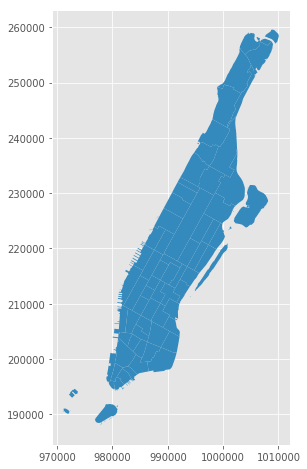

In [3]:
nyc_taxi_analyzer = contest_helper.NycTaxiAnalyzer('nyc_tlc/misc/taxi_zone_lookup.csv',
                                                   'nyc_tlc/misc/taxi_zones/taxi_zones.shp',
                                                   borough='Manhattan',
                                                   first_datetime=fd, last_datetime=ld)

nyc_taxi_analyzer.describe_shape()


# [Question 2]
TODO: load Manhattan data: from 2018-04 to 2018-06, call filter_abnormal_data to filter data

filter_abnormal_data is defined in contest_helper.NycTaxiAnalyzer

## Data Prepare

In [ ]:
# please put your solution here

In [ ]:
# Validate [Question 2]
print('sample_manhattan:', sample_manhattan.shape)

In [ ]:
# filter too large total_amount, trip_distance, trip_duration
start = time.time()

m = np.mean(sample_manhattan['total_amount'])
s = np.std(sample_manhattan['total_amount'])
print('total_amount m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] <= m + 10*s]
#sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] >= m - 10*s]
print('filter total_amount:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_distance'])
s = np.std(sample_manhattan['trip_distance'])
print('trip_distance m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] <= m + 20*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] >= m - 20*s]
print('filter trip_distance:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_duration'])
s = np.std(sample_manhattan['trip_duration'])
print('trip_duration m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] <= m + 2*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] >= m - 2*s]
print('filter trip_duration:', sample_manhattan.shape, time.time()-start)

print('sample_manhattan.shape:', sample_manhattan.shape)

In [ ]:
# append, change and drop columns
start = time.time()
sample_manhattan['store_and_fwd_flag'] = sample_manhattan['store_and_fwd_flag'].map(lambda x: x == 'N' and 0 or 1)
print('store_and_fwd_flag:', time.time()-start)

sample_manhattan['tpep_pickup_5min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(5*60)
print('tpep_pickup_5min_id:', time.time()-start)
sample_manhattan['tpep_pickup_15min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(15*60)
print('tpep_pickup_15min_id:', time.time()-start)
sample_manhattan['tpep_pickup_30min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(30*60)
print('tpep_pickup_30min_id:', time.time()-start)

sample_manhattan.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)  # , 'tpep_pickup_date', 'tpep_dropoff_date'
print('sample_manhattan.shape:', sample_manhattan.shape)

# [Question 3]

In [ ]:
# TODO: Show first 5 rows of sample_manhattan [Question 3.1]

# please put your solution here


In [ ]:
# TODO: Show statistics of sample_manhattan [Question 3.2]

# please put your solution here

# [Challenge Question]

In [ ]:
# TODO: Add new prediction algorithm or change parameters of above 4 prediction algorithms

# please put your solution here

## Feature Prepare

In [ ]:
def get_sample_group(id_name):
    sample_group = sample_manhattan.groupby([id_name, 'PULocationID'])
    sample_count = sample_group.count()
    sample_count.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_count:', sample_count.shape)
    sample_mean = sample_group.mean()
    sample_mean.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_mean:', sample_mean.shape)
    sample_sum = sample_group.sum()
    sample_sum.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_sum:', sample_sum.shape)
    sample_dropoff_group = sample_manhattan.groupby([id_name, 'DOLocationID'])
    sample_dropoff_count = sample_dropoff_group.count()
    sample_dropoff_count.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_count:', sample_dropoff_count.shape)
    sample_dropoff_mean = sample_dropoff_group.mean()
    sample_dropoff_mean.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_mean:', sample_dropoff_mean.shape)
    sample_dropoff_sum = sample_dropoff_group.sum()
    sample_dropoff_sum.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_sum:', sample_dropoff_sum.shape)
    return sample_count, sample_mean, sample_sum, sample_dropoff_count, sample_dropoff_mean, sample_dropoff_sum

In [ ]:
sample_5min_count, sample_5min_mean, sample_5min_sum, sample_5min_dropoff_count, sample_5min_dropoff_mean, sample_5min_dropoff_sum = get_sample_group('tpep_pickup_5min_id')
sample_15min_count, sample_15min_mean, sample_15min_sum, sample_15min_dropoff_count, sample_15min_dropoff_mean, sample_15min_dropoff_sum = get_sample_group('tpep_pickup_15min_id')
sample_30min_count, sample_30min_mean, sample_30min_sum, sample_30min_dropoff_count, sample_30min_dropoff_mean, sample_30min_dropoff_sum = get_sample_group('tpep_pickup_30min_id')

In [ ]:
sample_5min_count.head()

In [ ]:
sample_5min_mean.head()

In [ ]:
sample_5min_sum.head()

In [ ]:
sample_5min_dropoff_count.head()

In [ ]:
sample_5min_dropoff_mean.head()

In [ ]:
sample_5min_dropoff_sum.head()

In [ ]:
def get_all(all_index, sample_count, sample_mean, sample_sum, sample_dropoff_count, sample_dropoff_mean, sample_dropoff_sum):
    all_count = all_index.join(sample_count, how='left')
    all_count.fillna(0, inplace=True)
    print('all_count:', all_count.shape)
    all_mean = all_index.join(sample_mean, how='left')
    all_mean.fillna(0, inplace=True)
    print('all_mean:', all_mean.shape)
    all_sum = all_index.join(sample_sum, how='left')
    all_sum.fillna(0, inplace=True)
    print('all_sum:', all_sum.shape)
    all_dropoff_count = all_index.join(sample_dropoff_count, how='left')
    all_dropoff_count.fillna(0, inplace=True)
    print('all_dropoff_count:', all_dropoff_count.shape)
    all_dropoff_mean = all_index.join(sample_dropoff_mean, how='left')
    all_dropoff_mean.fillna(0, inplace=True)
    print('all_dropoff_mean:', all_dropoff_mean.shape)
    all_dropoff_sum = all_index.join(sample_dropoff_sum, how='left')
    all_dropoff_sum.fillna(0, inplace=True)
    print('all_dropoff_sum:', all_dropoff_sum.shape)
    all_xmin = all_count.copy()
    all_xmin = all_xmin.join(all_mean, lsuffix='_count', rsuffix='_mean')
    all_xmin = all_xmin.join(all_sum, rsuffix='_sum')
    all_xmin = all_xmin.join(all_dropoff_count, rsuffix='_dropoff_count')
    all_xmin = all_xmin.join(all_dropoff_mean, rsuffix='_dropoff_mean')
    all_xmin = all_xmin.join(all_dropoff_sum, rsuffix='_dropoff_sum')
    print('all_xmin:', all_xmin.shape)
    return all_xmin

In [ ]:
all_5min = get_all(all_5min_index, sample_5min_count, sample_5min_mean, sample_5min_sum, sample_5min_dropoff_count, sample_5min_dropoff_mean, sample_5min_dropoff_sum)
all_15min = get_all(all_15min_index, sample_15min_count, sample_15min_mean, sample_15min_sum, sample_15min_dropoff_count, sample_15min_dropoff_mean, sample_15min_dropoff_sum)
all_30min = get_all(all_30min_index, sample_30min_count, sample_30min_mean, sample_30min_sum, sample_30min_dropoff_count, sample_30min_dropoff_mean, sample_30min_dropoff_sum)

In [ ]:
all_5min.head()

In [ ]:
def get_all_features(all_xmin, all_static):
    all_xmin_features = all_static.copy()
    all_xmin_features['value'] = all_xmin['VendorID_count']
    all_xmin_features['5min_ago'] = all_xmin['VendorID_count'].shift(manhattan_location_num)
    all_xmin_features['5min_10min_ago'] = all_xmin['VendorID_count'].shift(2*manhattan_location_num)
    all_xmin_features['10min_ago'] = all_xmin_features['5min_ago'] + all_xmin_features['5min_10min_ago']
    all_xmin_features['10min_15min_ago'] = all_xmin['VendorID_count'].shift(3*manhattan_location_num)
    all_xmin_features['15min_ago'] = all_xmin_features['10min_ago'] + all_xmin_features['10min_15min_ago']
    all_xmin_features['15min_20min_ago'] = all_xmin['VendorID_count'].shift(4*manhattan_location_num)
    all_xmin_features['20min_ago'] = all_xmin_features['15min_ago'] + all_xmin_features['15min_20min_ago']
    all_xmin_features['20min_25min_ago'] = all_xmin['VendorID_count'].shift(5*manhattan_location_num)
    all_xmin_features['25min_ago'] = all_xmin_features['20min_ago'] + all_xmin_features['20min_25min_ago']
    all_xmin_features['25min_30min_ago'] = all_xmin['VendorID_count'].shift(6*manhattan_location_num)
    all_xmin_features['30min_ago'] = all_xmin_features['25min_ago'] + all_xmin_features['25min_30min_ago']
    all_xmin_features['5min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(manhattan_location_num)
    all_xmin_features['5min_10min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(2*manhattan_location_num)
    all_xmin_features['10min_ago_drop'] = all_xmin_features['5min_ago_drop'] + all_xmin_features['5min_10min_ago_drop']
    all_xmin_features['10min_15min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(3*manhattan_location_num)
    all_xmin_features['15min_ago_drop'] = all_xmin_features['10min_ago_drop'] + all_xmin_features['10min_15min_ago_drop']
    all_xmin_features['15min_20min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(4*manhattan_location_num)
    all_xmin_features['20min_ago_drop'] = all_xmin_features['15min_ago_drop'] + all_xmin_features['15min_20min_ago_drop']
    all_xmin_features['20min_25min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(5*manhattan_location_num)
    all_xmin_features['25min_ago_drop'] = all_xmin_features['20min_ago_drop'] + all_xmin_features['20min_25min_ago_drop']
    all_xmin_features['25min_30min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(6*manhattan_location_num)
    all_xmin_features['30min_ago_drop'] = all_xmin_features['25min_ago_drop'] + all_xmin_features['25min_30min_ago_drop']
    all_xmin_features['1day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24)
    all_xmin_features['7day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*7)
    all_xmin_features['14day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*14)
    all_xmin_features['21day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*21)
    all_xmin_features['28day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*28)
    all_xmin_features.fillna(0, inplace=True)
    print('all_xmin_features:', all_xmin_features.shape)
    return all_xmin_features

In [ ]:
all_5min_features = get_all_features(all_5min, all_5min_static)
all_15min_features = get_all_features(all_15min, all_15min_static)
all_30min_features = get_all_features(all_30min, all_30min_static)

In [ ]:
all_5min_features.head()

## Train and Validate

We split all data into train and validate part. We demonstrate 4 methods to forecast requests: XGBoost, LightGBM, linear regression implemented using sklearn and linear regression implemented using TensorFlow, and evaluate the models using mean absolute error (MAE). We also visualize the prediction results between 2018-01-01 00:00:00 and 2018-01-01 00:05:00 using `geopandas` (the darker the color, the more demand), and we can visualize any time slot using this method.

In [ ]:
train_X_5min = all_5min_features[:int(train_valid_split_5min_id)*manhattan_location_num]
print('train_X_5min:', train_X_5min.shape)
valid_X_5min = all_5min_features[int(train_valid_split_5min_id)*manhattan_location_num:int(last_5min_id)*manhattan_location_num]
print('valid_X_5min:', valid_X_5min.shape)
train_Y_5min = train_X_5min['value'].values
print('train_Y_5min:', len(train_Y_5min))
valid_Y_5min = valid_X_5min['value'].values
print('valid_Y_5min:', len(valid_Y_5min))

train_X_15min = all_15min_features[:int(train_valid_split_15min_id)*manhattan_location_num]
print('train_X_15min:', train_X_15min.shape)
valid_X_15min = all_15min_features[int(train_valid_split_15min_id)*manhattan_location_num:int(last_15min_id)*manhattan_location_num]
print('valid_X_15min:', valid_X_15min.shape)
train_Y_15min = train_X_15min['value'].values
print('train_Y_15min:', len(train_Y_15min))
valid_Y_15min = valid_X_15min['value'].values
print('valid_Y_15min:', len(valid_Y_15min))

train_X_30min = all_30min_features[:int(train_valid_split_30min_id)*manhattan_location_num]
print('train_X_30min:', train_X_30min.shape)
valid_X_30min = all_30min_features[int(train_valid_split_30min_id)*manhattan_location_num:int(last_30min_id)*manhattan_location_num]
print('valid_X_30min:', valid_X_30min.shape)
train_Y_30min = train_X_30min['value'].values
print('train_Y_30min:', len(train_Y_30min))
valid_Y_30min = valid_X_30min['value'].values
print('valid_Y_30min:', len(valid_Y_30min))

In [ ]:
pickle.dump((train_X_5min, valid_X_5min, train_Y_5min, valid_Y_5min), open('train_valid_5min.pickle', 'wb'), protocol=2)
pickle.dump((train_X_15min, valid_X_15min, train_Y_15min, valid_Y_15min), open('train_valid_15min.pickle', 'wb'), protocol=2)
pickle.dump((train_X_30min, valid_X_30min, train_Y_30min, valid_Y_30min), open('train_valid_30min.pickle', 'wb'), protocol=2)

In [ ]:
train_X_5min, valid_X_5min, train_Y_5min, valid_Y_5min = pickle.load(open('train_valid_5min.pickle', 'rb'))
train_X_15min, valid_X_15min, train_Y_15min, valid_Y_15min = pickle.load(open('train_valid_15min.pickle', 'rb'))
train_X_30min, valid_X_30min, train_Y_30min, valid_Y_30min = pickle.load(open('train_valid_30min.pickle', 'rb'))

In [ ]:
train_X_5min.head()

In [ ]:
train_X_5min.describe()

In [ ]:
valid_X_5min.head()

In [ ]:
valid_X_5min.describe()

In [ ]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('value', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('value', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    param['max_depth'] = 6  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'
    param['objective'] = 'reg:linear'
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 100

    bst = xgb.train(param, xg_train, num_round, watchlist)

    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))
    
    pred = bst.predict(xg_test)
    return pred

In [ ]:
def lr_train_validate(train_X, train_Y, test_X, test_Y):
    rfc = LinearRegression()
    rfc.fit(train_X.drop('value', axis=1), train_Y.astype(np.float))
    pred = rfc.predict(test_X.drop('value', axis=1))
    return pred

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[train_X_5min.shape[1]-1]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

def tf_train_validate(train_X, train_Y, test_X, test_Y):
    EPOCHS = 10
    model = build_model()
    model.summary()
    history = model.fit(train_X.drop('value', axis=1), train_Y, epochs=EPOCHS, validation_split = 0.2, verbose=2)
    loss, mae, mse = model.evaluate(test_X.drop('value', axis=1), test_Y, verbose=1)
    pred = model.predict(test_X.drop('value', axis=1)).flatten()
    return pred

In [ ]:
def lgb_train_validate(train_X, train_Y, test_X, test_Y):
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(train_X.drop('value', axis=1), train_Y)
    lgb_eval = lgb.Dataset(test_X.drop('value', axis=1), test_Y, reference=lgb_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)
    
    print('Starting predicting...')
    # predict
    pred = gbm.predict(test_X.drop('value', axis=1), num_iteration=gbm.best_iteration)
    # eval
    print('The mae of prediction is:', mae(test_Y, pred))
    return pred

In [ ]:
valid_pred_5min.head()

In [ ]:
valid_pred_5min_group